## Dry Bean Classification

**Contents**

* Problem description
* EDA procedure
* Analysis (model building and training)
* Result
* Discussion/conclusion.

Data Source

_Dry Bean Dataset_. (2020). UCI Machine Learning Repository. Retrieved August 15, 2022 from https://archive.ics.uci.edu/ml/datasets/dry+bean+dataset.



In [82]:
# Dependencies
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set()


### Problem

The Dry Bean Dataset contains 13,611 observations across 7 types of beans, and documents 16 attributes from high resolution photos taken.

In order to facilitate research-grade identification of these 7 bean types, the goal is to build a model which will take the values of these 17 attributes and classify it correctly.

### Data Import and EDA

In [71]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('data/Dry_Bean_Dataset.arff')
df = pd.DataFrame(data[0])

print(df.head())

      Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395.0    610.291       208.178117       173.888747      1.197191   
1  28734.0    638.018       200.524796       182.734419      1.097356   
2  29380.0    624.110       212.826130       175.931143      1.209713   
3  30008.0    645.884       210.557999       182.516516      1.153638   
4  30140.0    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812     28715.0     190.141097  0.763923  0.988856   0.958027   
1      0.411785     29172.0     191.272750  0.783968  0.984986   0.887034   
2      0.562727     29690.0     193.410904  0.778113  0.989559   0.947849   
3      0.498616     30724.0     195.467062  0.782681  0.976696   0.903936   
4      0.333680     30417.0     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  \
0     0.913358      0.00

Taking the first look at the data, all of the features are numerical and most are dimensional. It will be good to verify that there are no missing values, and that there is enough variance within each feature.

In [72]:
x = df.drop(columns=["Class"])

# We could use MultiLabelBinarizer(), but we can also map since we know our values
classes = df['Class'].unique()
class_map = defaultdict(int)
for idx, cstr in enumerate(classes):
    class_map[cstr] = idx
df['Class'] = df['Class'].map(class_map)
y = df['Class']

# For data display
clean_classes = [str(c).replace('b\'','').replace('\'', '') for c in classes]
print(clean_classes)

['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON']


The 'Class' label had some strange formatting that needed cleaning for readibility.

#### EDA: Data Cleaning

The primary concern for this dataset is checking for null/missing values. 

In [51]:
# Check for null values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

print("Property | isnull() | null-like")
for c in df.columns:
    string_null = np.array([x in null_like for x in df[c]])
    print(c, df[c].isnull().sum(), string_null.sum())

Property | isnull() | null-like
Area 0 0
Perimeter 0 0
MajorAxisLength 0 0
MinorAxisLength 0 0
AspectRation 0 0
Eccentricity 0 0
ConvexArea 0 0
EquivDiameter 0 0
Extent 0 0
Solidity 0 0
roundness 0 0
Compactness 0 0
ShapeFactor1 0 0
ShapeFactor2 0 0
ShapeFactor3 0 0
ShapeFactor4 0 0
Class 0 0


It looks like our data is complete, no need to remove or fill in any values.

#### EDA: Data Distribution

Both of the model training methods to be used can be thrown off by features of different scale. Before scaling, lets look at the feature distributions using the actual values.

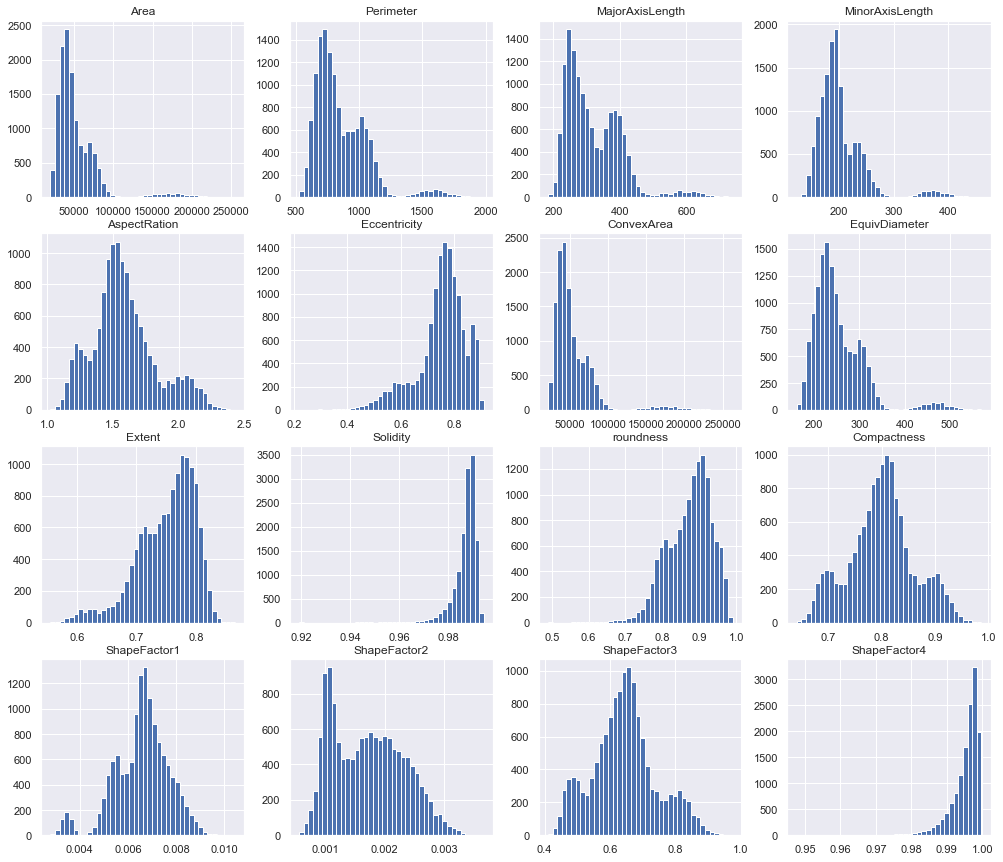

In [7]:
fig, a = plt.subplots(4,4)
fig.set_figheight(12)
fig.set_figwidth(14)
fig.tight_layout()

for i, c in enumerate(x.columns):
  data = x[c]
  ax = a.flat[i]
  ax.hist(data, bins=40)
  ax.set_title(c)


Looking at these distributions, there are clear identifiable peaks that suggest concentrations of different variants. "ShapeFactor4" and "Solidity" are the only two which are heavily skewed and concentrated to one side.

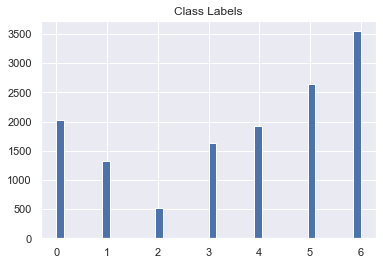

In [73]:
# Distribution of labels
plt.hist(y, bins=40)
plt.title("Class Labels")
plt.show()

Label distribution shows we have a good number of observations for each Class except for 2, which is close to 500. This is worth keeping in mind later when looking at confusion matrices.

<AxesSubplot:>

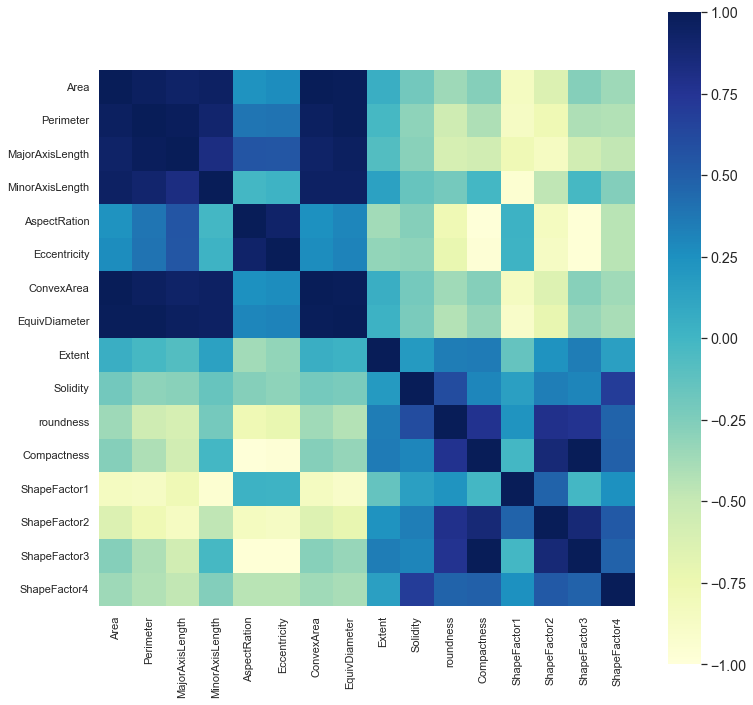

In [8]:
# Look into feature correlation
corr = x.corr()
plt.subplots(figsize=(12,12))
sns.set(font_scale=1.3)
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

Overall, strong correlation is seen where it would be expected, between size values such as 'Area' and 'Perimeter'. The models being used here should be able to handle the potential redundancy and with this particular dataset if there is a difference between the length of two axis, for instance, it could be a significant piece of information.

### Model Building & Training

Before training, the data must be split into train and test sets, and then scaled.

Models that will be used are a supervised Multi-Layer Perceptron, and an unsupervised Non-negative Matrix Factorization.

These are two distinctly different approaches, and it will be interesting to see how they compare.

In [49]:
# Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
# Normalize features by scaling
sc_x = StandardScaler()
x_trainscaled = sc_x.fit_transform(x_train)
x_testscaled = sc_x.transform(x_test)

print(x_trainscaled[:3])
print(y_train[:6])

[[ 0.54800361  1.1566591   0.88861799  0.46505382  0.7796369   0.82099699
   0.5630067   0.73632107 -1.51613667 -1.55031929 -2.68279697 -0.83151084
  -0.73558477 -1.0176345  -0.84124461 -0.03499052]
 [-0.49571643 -0.56510525 -0.55829576 -0.4785994  -0.310855   -0.03240435
  -0.49659129 -0.53398317  0.27482217  0.17058047  0.41684867  0.21789479
   0.44749833  0.3231135   0.18071361  0.33939523]
 [-0.59035823 -0.70473599 -0.75163031 -0.52007428 -0.62286524 -0.39506015
  -0.58875654 -0.67125275 -0.63563619 -0.21027662  0.54578719  0.55712255
   0.52305747  0.7089937   0.52918033 -0.031     ]]
2663    1
7648    5
7480    5
3339    1
4179    3
8749    5
Name: Class, dtype: int64


Multi-Layer Perceptron is available as a classifier module from sklearn's neural network package.

Before trying to tune, let's look at its default performance.

In [106]:
# Multi-Layer Perceptron set-up and training
clf = MLPClassifier( hidden_layer_sizes=(128,64,32), max_iter=400)
clf.fit(x_trainscaled, y_train)
y_pred = clf.predict(x_testscaled)
print(clf.score(x_testscaled, y_test))

0.9298567756151304


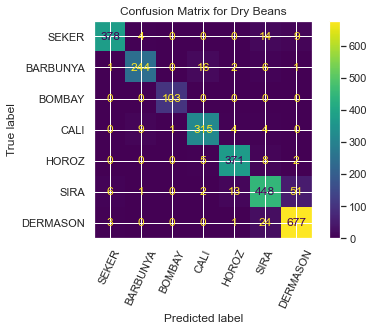

In [74]:
conf_fig = plot_confusion_matrix(clf, x_testscaled, y_test, display_labels=clean_classes)
plt.title("Confusion Matrix for Dry Beans")
plt.xticks(rotation = 65)
plt.show()

Off to a good start, MLP seems to only really be a little confused between Sira and Dermason. We can probably assume that these two seeds look very similar. Also, the Class 2 seed, 'Bombay', is classifying well despite having less observations.

Is there room to improve on the accuracy score of 0.930 with tuning?

In [12]:
param_grid = [
    {
        'activation' : ['logistic', 'tanh'], # 'identity', 'relu',
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [(4,), (16,), (32,), (128,64,32)]
    }
    ]

cv_clf = GridSearchCV(MLPClassifier(max_iter=400), param_grid, cv=3, scoring='accuracy')
cv_clf.fit(x_trainscaled, y_train)


print("Best parameters set found on development set:")
print(cv_clf.best_params_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_mult

Best parameters set found on development set:
{'activation': 'logistic', 'hidden_layer_sizes': (32,), 'solver': 'adam'}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#  activation options: 'identity', 'relu' -> best params accuracy  0.9349
split_1_best_params = {'activation': 'relu', 'hidden_layer_sizes': (32,), 'solver': 'adam'}
#  activation options: 'logistic', 'tanh' -> best params accuracy 0.935
split_2_best_params = {'activation': 'tanh', 'hidden_layer_sizes': (16,), 'solver': 'adam'}

best_clf = MLPClassifier( hidden_layer_sizes=(16,),
                     activation="tanh",
                     solver="adam",
                     random_state=1,
                     max_iter=400)
best_clf.fit(x_trainscaled, y_train)
best_y_pred = best_clf.predict(x_testscaled)
print(best_clf.score(x_testscaled, y_test))

0.9353654058024238


After tuning, the optimal MLPClassifier model produced an accuracy score of **0.935**.

### Comparing to an Unsupervised Approach

The deep learning MLP produced a 0.935 accuracy score, it will be interesting to see if an unsupervised approach can compete.



In [123]:
# Utility functions for predicting from output components
def predict(weights):
    sortedW = np.argsort(weights)
    k, maxValue = sortedW.shape
    predictions = [[sortedW[i][maxValue - 1]] for i in range(k)]
    topics = np.empty(k, dtype = np.int64)
    for i in range(k):
        topics[i] = predictions[i][0]
    return topics

# Matching model weights to labels
def best_labels(y_true, y_pred):
    """
    Returns label indices
    """
    df = pd.DataFrame()
    df['Class'] = y_true
    perms = list(itertools.permutations([0, 1, 2, 3, 4, 5, 6]))
    classes = [0,1,2,3,4,5,6]
    acc = 0
    best_perm = []
    current = {}
    for perm in perms:
        for i in range(len(classes)):
            current[classes[i]] = perm[i]
            if len(current) == 7:
                df['test'] = df['Class'].map(current)
                current_accuracy = accuracy_score(df['test'], y_pred)
                if current_accuracy > acc:
                    df['Predicted'] = df['test']
                    acc = current_accuracy
                    best_perm = perm
    df = df.drop(columns=["test"])
    return best_perm, acc

def output_scores(model, xtrain, xtest, ytrain, ytest):
    y_train_transform = predict(model.transform(xtrain))
    label_order_train, train_accuracy = best_labels(ytrain, y_train_transform)

    y_test_transform = predict(model.transform(xtest))
    label_order_test, test_accuracy = best_labels(ytest, y_test_transform)

    print(f"Train acc: {train_accuracy}, Test acc: {test_accuracy}")
    return train_accuracy, test_accuracy

In [32]:
# Set up and train NMF
train_mat = csr_matrix(x_train)
nmf_mod = NMF(n_components=7, init='nndsvda', solver = 'mu', l1_ratio = 0.5, random_state = 57)
nmf_mod.fit(train_mat)

NMF(init='nndsvda', l1_ratio=0.5, n_components=7, random_state=57, solver='mu')

In [97]:
# Predict and evaluate from NMF
output_scores(nmf_mod, x_train, x_test, y_train, y_test)

Train acc: 0.45518001469507713, Test acc: 0.45023870730811605


In [85]:
# NMF should perform better with normalized values, and we need to scale positive
mmscale = MinMaxScaler() # Scales to a 0 - 1 range
x_train_mm = mmscale.fit_transform(x_train)
x_test_mm = mmscale.transform(x_test)
# Condensed matrix format for NSF - shouldn't significantly impact this dataset
train_mat_mm = csr_matrix(x_train_mm)
test_mat_mm = csr_matrix(x_test_mm)

print(x_train_mm[:3])

[[0.20791132 0.39606431 0.38277567 0.29837077 0.53322442 0.87670141
  0.20546878 0.33175081 0.39678281 0.80924792 0.45013413 0.31221028
  0.38495948 0.18255813 0.26647332 0.90789176]
 [0.07723872 0.14326518 0.15951607 0.17252451 0.34206707 0.76338682
  0.07541935 0.14746773 0.68616575 0.91578303 0.82137608 0.49890508
  0.55906417 0.44867643 0.4456572  0.93910836]
 [0.06538967 0.12276381 0.12968444 0.16699339 0.28737335 0.71523341
  0.06410748 0.12755403 0.53905398 0.89220545 0.83681894 0.55925549
  0.5701836  0.52526784 0.50675522 0.90822449]]


In [ ]:
# Test NMF with default params with scaled inputs
nmf_mod = NMF(n_components=7, max_iter=1000)
nmf_mod.fit(train_mat_mm)
output_scores(nmf_mod, train_mat_mm, test_mat_mm, y_train, y_test)

In [118]:
# Tuning for loss parameters with 'mu' solver
best_score = 0
best_model = None

for b_loss in ['kullback-leibler', 'frobenius']:
    for l1 in [0, 0.1, 0.5]:
        nmf_mod_k = NMF(n_components=7, solver='mu', init='nndsvda', beta_loss=b_loss, l1_ratio=l1, max_iter=1500, random_state=57)
        nmf_mod_k.fit(train_mat_mm)
        print(f'Params | beta_loss:{b_loss} | l1_ratio:{l1}')
        train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
        if test_score > best_score:
            best_model = nmf_mod_k
            best_score = test_score

Params | beta_loss:kullback-leibler | l1_ratio:0
Train acc: 0.5601579720793534, Test acc: 0.554535438854205
Params | beta_loss:kullback-leibler | l1_ratio:0.1
Train acc: 0.5601579720793534, Test acc: 0.554535438854205
Params | beta_loss:kullback-leibler | l1_ratio:0.5
Train acc: 0.5601579720793534, Test acc: 0.554535438854205
Params | beta_loss:frobenius | l1_ratio:0
Train acc: 0.5947832476120499, Test acc: 0.5897906720528828
Params | beta_loss:frobenius | l1_ratio:0.1
Train acc: 0.5947832476120499, Test acc: 0.5897906720528828
Params | beta_loss:frobenius | l1_ratio:0.5
Train acc: 0.5947832476120499, Test acc: 0.5897906720528828


No changes when tuning l1_ratio, but we did confirm better performance with frobenius beta_loss.

Next round we will tune for the 'cd' solver.

In [127]:
# Second round of tuning
# testing 'cd' solver with tolerance values, and larger number of max iterations

for tol in [1e-6, 1e-4, 1e-2]:
    # increased max_iter to 5000 for lower tolerance value
    nmf_mod_k = NMF(n_components=7, solver='cd', init='nndsvda', beta_loss='frobenius', tol=tol, max_iter=5000, random_state=57)
    nmf_mod_k.fit(train_mat_mm)
    print(f'Params | solver:cd | tol:{tol}')
    train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
    if test_score > best_score:
        best_model = nmf_mod_k
        best_score = test_score

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Params | solver:cd | tol:1e-06
Train acc: 0.5045003673769287, Test acc: 0.5053250091810503
Params | solver:cd | tol:0.0001
Train acc: 0.43681116825863336, Test acc: 0.442159383033419
Params | solver:cd | tol:0.01
Train acc: 0.6520022042615724, Test acc: 0.6467131839882483


In [128]:
# Interesting pattern - can we push tolerances further?
for tol in [1e-8, 1]:
    # increased max_iter to 5000 for lower tolerance value
    nmf_mod_k = NMF(n_components=7, solver='cd', init='nndsvda', beta_loss='frobenius', tol=tol, max_iter=10000, random_state=57)
    nmf_mod_k.fit(train_mat_mm)
    print(f'Params | solver:cd | tol:{tol}')
    train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
    if test_score > best_score:
        best_model = nmf_mod_k
        best_score = test_score

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Params | solver:cd | tol:1e-08
Train acc: 0.5124908155767818, Test acc: 0.5134043334557473
Params | solver:cd | tol:1
Train acc: 0.5572189566495224, Test acc: 0.5585751009915534


In [129]:
# Lastly lets try tuning tolerance with 'mu' colver
for tol in [0.001, 0.01, 0.1]:
    # increased max_iter to 5000 for lower tolerance value
    nmf_mod_k = NMF(n_components=7, solver='mu', init='nndsvda', beta_loss='frobenius', tol=tol, max_iter=10000, random_state=57)
    nmf_mod_k.fit(train_mat_mm)
    print(f'Params | solver:mu | tol:{tol}')
    train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
    if test_score > best_score:
        best_model = nmf_mod_k
        best_score = test_score

Params | solver:mu | tol:0.001
Train acc: 0.4918258633357825, Test acc: 0.49651120088138084
Params | solver:mu | tol:0.01
Train acc: 0.4927443056576047, Test acc: 0.5071612192434815
Params | solver:mu | tol:0.1
Train acc: 0.4940301249081558, Test acc: 0.5027543150936468


It looks like closer to the default of 1e-4 works better for the 'mu' solver, let's try one more round.

In [130]:
for tol in [1e-4, 1e-6, 1e-8]:
    # increased max_iter to 5000 for lower tolerance value
    nmf_mod_k = NMF(n_components=7, solver='mu', init='nndsvda', beta_loss='frobenius', tol=tol, max_iter=10000, random_state=57)
    nmf_mod_k.fit(train_mat_mm)
    print(f'Params | solver:mu | tol:{tol}')
    train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
    if test_score > best_score:
        best_model = nmf_mod_k
        best_score = test_score

Params | solver:mu | tol:0.0001
Train acc: 0.5947832476120499, Test acc: 0.5897906720528828
Params | solver:mu | tol:1e-06
Train acc: 0.7313556208670096, Test acc: 0.726771942710246


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Params | solver:mu | tol:1e-08
Train acc: 0.7377847171197649, Test acc: 0.7359529930224018


In [131]:
# Can we optimize further with more iterations?
for tol in [1e-8, 1e-10]:
    # increased max_iter to 5000 for lower tolerance value
    nmf_mod_k = NMF(n_components=7, solver='mu', init='nndsvda', beta_loss='frobenius', tol=tol, max_iter=100000, random_state=57)
    nmf_mod_k.fit(train_mat_mm)
    print(f'Params | solver:mu | tol:{tol}')
    train_score, test_score = output_scores(nmf_mod_k, train_mat_mm, test_mat_mm, y_train, y_test)
    if test_score > best_score:
        best_model = nmf_mod_k
        best_score = test_score

Params | solver:mu | tol:1e-08
Train acc: 0.6280308596620132, Test acc: 0.6276165993389644


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Params | solver:mu | tol:1e-10
Train acc: 0.669452608376194, Test acc: 0.6683804627249358


### Comparing Results

The optimized MLP solution, which took considerably less tuning and less time to train, achieved an accuracy score of 0.935 on the test set, whereas the optimized NMF solution achieved 0.736 on the test set.

### Conclusion

Preparing the data for both the Multi-layer Perceptron training and the Non-negative Matrix Factorization was pretty straightforward in this case, the real difference between the two was in performance and ease of getting there. MLP required minimal tuning, and essentially achieved a workable model right out of the box. Being unsupervised, NMF required some additional utility functions, and needed extensive parameter tuning. In the end, the best NMF solution took over 5min to train whereas each model training for MLP took less than a minute. Familiarity with Non-negative Matrix Factorization may help with achieving optimal parameters more quickly.

Perhaps there are datasets where a mathematically simpler Matrix Factorization solution will function well, but in this case the MLP Deep Learning approach was a clear winner.